In [4]:
%load_ext autoreload
%autoreload 2
import torch
from torch.autograd import Variable
import seaborn as sns
import torch.nn.functional as F
import math
import os
import matplotlib.ticker as mtick
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from fc_nets import *

sns.set(font_scale=1.1)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True

colors = ['cornflowerblue', 'midnightblue']
label_size = 16
seed = 3

X = torch.tensor(np.array([[-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5]]).T / 4 + 0.07).float()
y = torch.tensor(0.345 + np.array([[-2, 1.5, 0, 0, 2, 1, 0, -1, 0, 1, 2, -1]]).T).float()
n = y.shape[0]
m = 100

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SGD, $\eta$=0.0002, decay at 2\% iterations 0.0002085922606056556 540.21747 48.66666666666667 0.040833331644535065
SGD, $\eta$=0.0002, decay at 50\% iterations 0.00016900205810088664 22.188341 26.666666666666668 0.2541666626930237


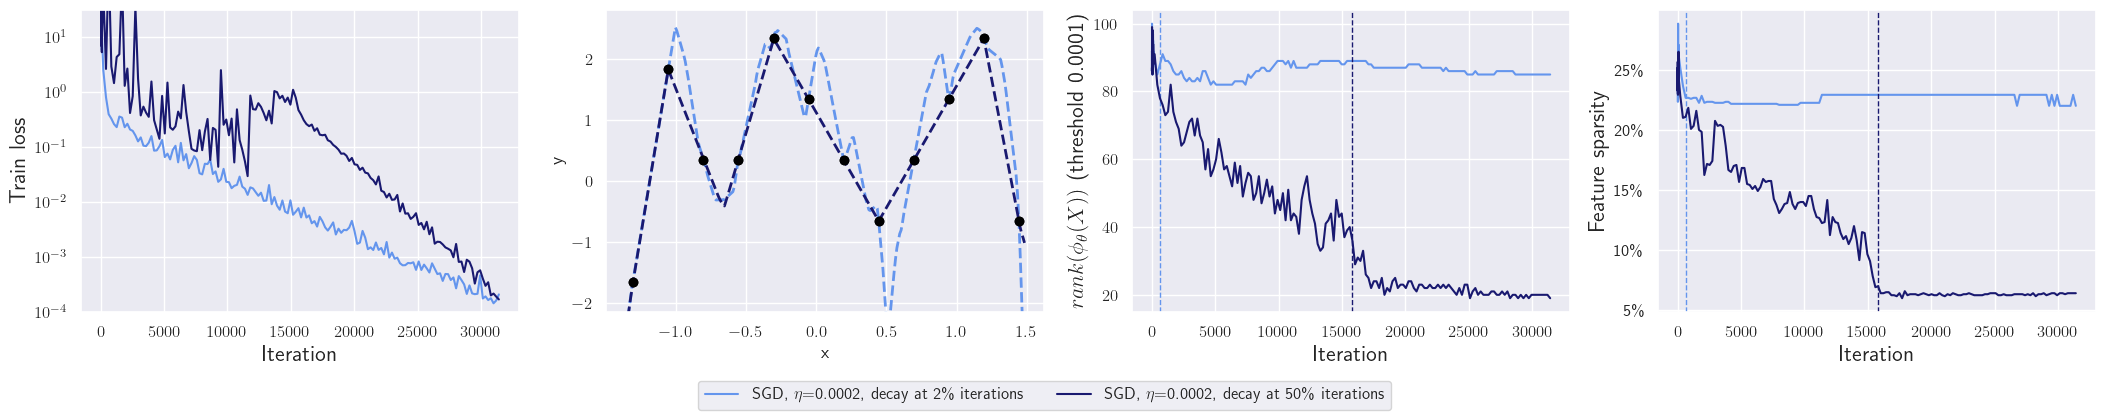

In [5]:
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.5, x_log_scale=x_log_scale)
lp, l0_threshold = 0.1, 0.1
l0_threshold_grad_matrix = 0.0001
X_eval = X
n_plots = 4

plt.figure(figsize = (26, 4))

warmup_mult_factor = 400.0
gammas = [0.0002, 0.0002]
schedule_lengths = [0.02, 0.5]
decay_factors = [2.5, 3.0]
batch_sizes = [1] * len(schedule_lengths)

nets_all = []
for i, (gamma, batch_size, schedule_length, decay_factor) in enumerate(zip(gammas, batch_sizes, schedule_lengths, decay_factors)):
    np.random.seed(seed)
    torch.manual_seed(seed)

    label = '{}, $\eta$={:.4f}'.format('SGD' if batch_size < n else 'GD', gamma) + ', decay at ' + str(int(schedule_length*100)) + r'\% iterations'

    net_init = FCNet2Layers(n_feature=1, n_hidden=m, biases=[True, False]) 
    net_init.init_blanc_et_al(init_scales=[1.0, 1.0]) 
    train_losses, test_losses, nets = train_fc_net(X, y, X, y, gamma, batch_size, net_init, iters_loss, num_iter=num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], iters_percentage_linear_warmup=schedule_length, gamma_warmup_factor_max=warmup_mult_factor*schedule_length, warmup_exponent=1.0) 
    nets_all.append(nets)

    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2))**0.5 for net in nets]
    feature_ranks = [np.linalg.svd((F.relu(net.layer1(X)) * net.layer2.weight).data.numpy())[1].sum() for net in nets]
    lp_norms_features_sing = np.array([(np.linalg.svd(net.features(X_eval))[1]**lp).sum() for net in nets])
    l0_norms_features_sing = np.array([(np.linalg.svd(net.features(X_eval))[1] > l0_threshold).sum() for net in nets])
    activation_frac_nonzeros = [((F.relu(net.layer1(X)) * net.layer2.weight).data.numpy() != 0).mean()*100 for net in nets]
    feature_sparsity = np.array([net.feature_sparsity(X, corr_threshold=0.999) for net in nets])
    relu_distances = [torch.abs((net_init.layer1.weight @ X.T + net_init.layer1.bias[:, None] > 0).float() - (net.layer1.weight @ X.T + net.layer1.bias[:, None] > 0).float()).mean() for net in nets]
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = torch.Tensor(np.random.uniform(X.min(), X.max(), n_params)[:, None])
    grad_matrix_ranks = compute_grad_matrix_ranks(nets, X_eval, l0_threshold_grad_matrix)
    
    
    print(label, train_losses[-1].item(), feature_ranks[-1], activation_frac_nonzeros[-1], relu_distances[-1].item())


    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i])  #, linestyle='--' if 'SGD' in label else 'solid')
    ax.set_yscale('log')
    ax.set_ylim(10**-4.0, 10**1.5)
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)
    
    ax = plt.subplot(1, n_plots, 2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(1.3*y.data.numpy().min(), 1.2*y.data.numpy().max())
    grid_step = 0.01
    x_grid = np.arange(X.data.numpy().min() - 5*grid_step, X.data.numpy().max() + 5*grid_step, grid_step)
    y_preds = nets[-1](torch.Tensor(x_grid.reshape(-1, 1))).detach()
    plt.plot(x_grid, y_preds, colors[i], lw=2, label=label, linestyle='--' if 'SGD' in label else 'solid')
    plt.scatter(X.data.numpy(), y.data.numpy(), color="black", zorder=3)

    grad_matrix_dims = [compute_grad_matrix_dim(net, X, corr_threshold=0.999) for net in nets]

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, grad_matrix_ranks, label=label, color=colors[i], linestyle='solid')
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$rank(\phi_\\theta(X))$ (threshold {})'.format(l0_threshold_grad_matrix), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, 100*feature_sparsity, label=label, color=colors[i])  #, linestyle='--' if 'SGD' in label else 'solid')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Feature sparsity', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.2), ncol=7)
plt.savefig("plots/1d_regression-loss_stabilization-gamma={}-batch_size={}-schedule_lengths={}-decay_factors={}.pdf".format(gamma, batch_size, schedule_lengths, decay_factors), bbox_inches='tight')
plt.show()

SGD, $\eta$=0.0002, decay at 2\% iterations 0.0001599380193511024 540.1831 48.66666666666667 0.040833331644535065
SGD, $\eta$=0.0002, decay at 50\% iterations 0.26857006549835205 12.731428 22.166666666666668 0.30416667461395264


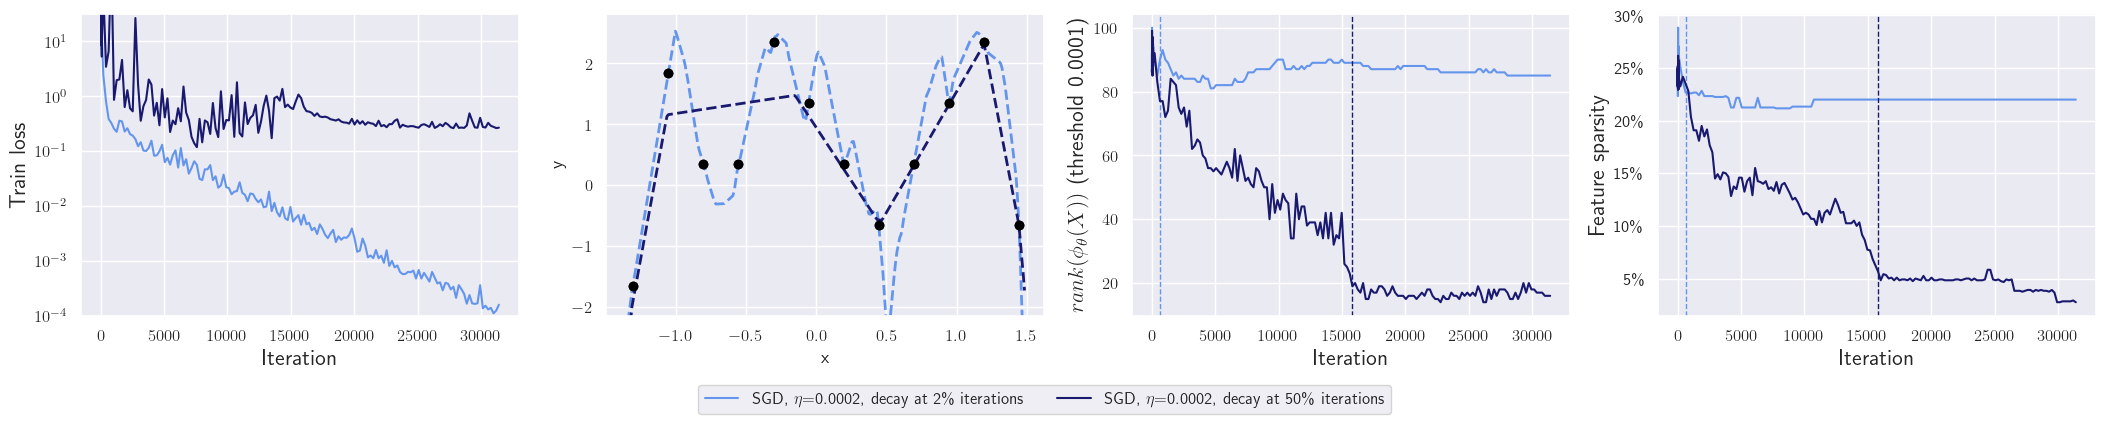

In [6]:
### Overregularization experiment with a bit stronger warmup.
x_log_scale = False
num_iter, iters_loss = get_iters_eval(n_iter_power=4.5, x_log_scale=x_log_scale)
lp, l0_threshold = 0.1, 0.1
l0_threshold_grad_matrix = 0.0001
X_eval = X
n_plots = 4

plt.figure(figsize = (26, 4))

warmup_mult_factor = 500.0
gammas = [0.0002, 0.0002]
schedule_lengths = [0.02, 0.5]
decay_factors = [2.5, 3.0]
batch_sizes = [1] * len(schedule_lengths)

nets_all = []
for i, (gamma, batch_size, schedule_length, decay_factor) in enumerate(zip(gammas, batch_sizes, schedule_lengths, decay_factors)):
    np.random.seed(seed)
    torch.manual_seed(seed)

    label = '{}, $\eta$={:.4f}'.format('SGD' if batch_size < n else 'GD', gamma) + ', decay at ' + str(int(schedule_length*100)) + r'\% iterations'

    net_init = FCNet2Layers(n_feature=1, n_hidden=100, biases=[True, False]) 
    net_init.init_blanc_et_al(init_scales=[1.0, 1.0]) 
    train_losses, test_losses, nets = train_fc_net(X, y, X, y, gamma, batch_size, net_init, iters_loss, num_iter=num_iter, thresholds=[int(schedule_length*num_iter)], decays=[decay_factor], iters_percentage_linear_warmup=schedule_length, gamma_warmup_factor_max=warmup_mult_factor*schedule_length, warmup_exponent=1.0) 
    nets_all.append(nets)

    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    l2_norms = [(np.sum(net.layer1.weight.data.numpy()**2) + np.sum(net.layer2.weight.data.numpy()**2))**0.5 for net in nets]
    feature_ranks = [np.linalg.svd((F.relu(net.layer1(X)) * net.layer2.weight).data.numpy())[1].sum() for net in nets]
    lp_norms_features_sing = np.array([(np.linalg.svd(net.features(X_eval))[1]**lp).sum() for net in nets])
    l0_norms_features_sing = np.array([(np.linalg.svd(net.features(X_eval))[1] > l0_threshold).sum() for net in nets])
    activation_frac_nonzeros = [((F.relu(net.layer1(X)) * net.layer2.weight).data.numpy() != 0).mean()*100 for net in nets]
    feature_sparsity = np.array([net.feature_sparsity(X, corr_threshold=0.999) for net in nets])
    relu_distances = [torch.abs((net_init.layer1.weight @ X.T + net_init.layer1.bias[:, None] > 0).float() - (net.layer1.weight @ X.T + net.layer1.bias[:, None] > 0).float()).mean() for net in nets]
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = torch.Tensor(np.random.uniform(X.min(), X.max(), n_params)[:, None])
    grad_matrix_ranks = compute_grad_matrix_ranks(nets, X_eval, l0_threshold_grad_matrix)
    
    
    print(label, train_losses[-1].item(), feature_ranks[-1], activation_frac_nonzeros[-1], relu_distances[-1].item())


    ax = plt.subplot(1, n_plots, 1)
    plt.plot(iters_loss, train_losses, label=label, color=colors[i])  #, linestyle='--' if 'SGD' in label else 'solid')
    ax.set_yscale('log')
    ax.set_ylim(10**-4.0, 10**1.5)
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Train loss', fontsize=label_size)

    ax = plt.subplot(1, n_plots, 2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim(1.3*y.data.numpy().min(), 1.2*y.data.numpy().max())
    grid_step = 0.01
    x_grid = np.arange(X.data.numpy().min() - 5*grid_step, X.data.numpy().max() + 5*grid_step, grid_step)
    y_preds = nets[-1](torch.Tensor(x_grid.reshape(-1, 1))).detach()
    plt.plot(x_grid, y_preds, colors[i], lw=2, label=label, linestyle='--' if 'SGD' in label else 'solid')
    plt.scatter(X.data.numpy(), y.data.numpy(), color="black", zorder=3)

    ax = plt.subplot(1, n_plots, 3)
    plt.plot(iters_loss, grad_matrix_ranks, label=label, color=colors[i], linestyle='solid')
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('$rank(\phi_\\theta(X))$ (threshold {})'.format(l0_threshold_grad_matrix), fontsize=label_size)

    ax = plt.subplot(1, n_plots, 4)
    plt.plot(iters_loss, 100*feature_sparsity, label=label, color=colors[i])  #, linestyle='--' if 'SGD' in label else 'solid')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
    if schedule_lengths[i] > 0:
        plt.axvline(x=schedule_lengths[i]*num_iter, color=colors[i], linestyle='--', linewidth=1)
    if x_log_scale:
        ax.set_xscale('log')
    plt.xlabel('Iteration', fontsize=label_size)
    plt.ylabel('Feature sparsity', fontsize=label_size)

plt.legend(loc='upper center', bbox_to_anchor=(-1.4, -0.2), ncol=7)
plt.savefig("plots/1d_regression-loss_stabilization-gamma={}-batch_size={}-schedule_lengths={}-decay_factors={}.pdf".format(gamma, batch_size, schedule_lengths, decay_factors), bbox_inches='tight')
plt.show()


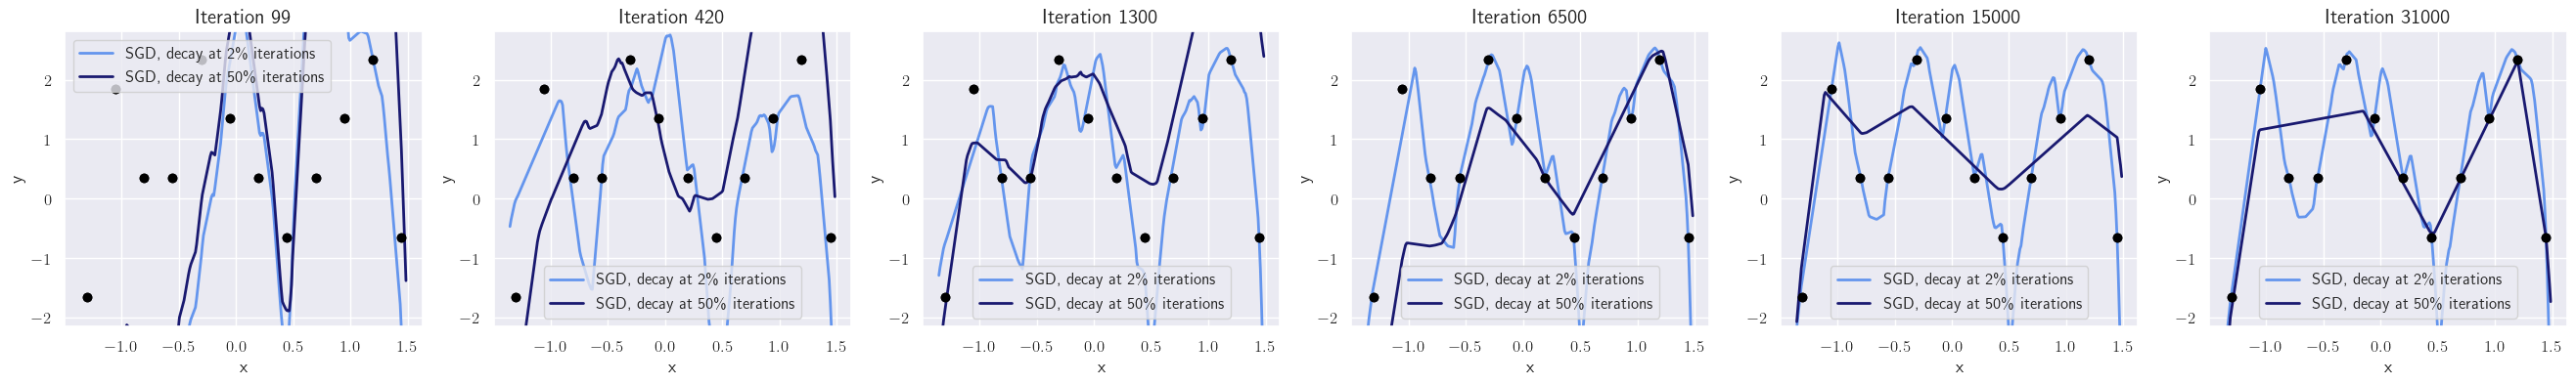

In [7]:
run_ids = [0, 1]
iter_ids = [99, 101, 105, 130, 170, 248]
# iter_ids = [99, 100, 248]

plt.figure(figsize = (33, 4))
for i, iter_id in enumerate(iter_ids):
    ax = plt.subplot(1, len(iter_ids), i+1)
    for run_id in run_ids:
        # label = '{} B={}, $\gamma$={:.4f} (iter={:.0f})'.format('SGD' if batch_sizes[run_id] < n else 'GD', batch_sizes[run_id], gammas[run_id], iters_loss[iter_id])
        label = ('SGD' if batch_size < n else 'GD') + ', decay at ' + str(int(schedule_lengths[run_id]*100)) + r'\% iterations'
        net = nets_all[run_id][iter_id]
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim(1.3*y.data.numpy().min(), 1.2*y.data.numpy().max())
        grid_step = 0.01
        x_grid = np.arange(X.data.numpy().min() - 5*grid_step, X.data.numpy().max() + 5*grid_step, grid_step)
        y_preds = net(torch.Tensor(x_grid.reshape(-1, 1))).detach()
        plt.plot(x_grid, y_preds, colors[run_id], lw=2.0, label=label)
        # iter_rounded = round(iters_loss[iter_id], -int(math.log10(iters_loss[iter_id])))
        iter_rounded = round(iters_loss[iter_id], -int(math.log10(iters_loss[iter_id]))+1)
        plt.title('Iteration {:.0f}'.format(iter_rounded), fontsize=15)
        plt.scatter(X.data.numpy(), y.data.numpy(), color="black", zorder=3)
    plt.legend()
plt.savefig("plots/1d_function_vis-gammas={}-batch_sizes={}-run_ids={}.pdf".format(gammas, batch_sizes, run_ids), bbox_inches='tight')
plt.show()